In [6]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,make_scorer,classification_report
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_validate,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [7]:
# !pip install umap-learn

In [8]:
np.set_printoptions(precision=6, suppress=True)

In [9]:

class FFT:
    def __init__(self,timeSeries,fs=160):
        self.getFFT(timeSeries,fs)

    def getFFT(self, timeSeries,fs=160):
        self.N = len(timeSeries)
        self.T = 1/fs
        self.t = np.arange(0,self.N/fs,self.T)
        f = np.fft.fftfreq(self.N,self.T)
        # self.data,self.f = np.abs(np.fft.fft(timeSeries))[f>0],f[f>0]
        self.data,self.f = np.real(np.fft.fft(timeSeries))[f>0],f[f>0]

    def plotFFT(self):
        plt.figure()
        plt.plot(self.f,(self.data)*(1/self.N))
        plt.show()
        return

    # filtragem da rede (intervalo indicado é de 0.5 até 42.0 hz)
    def bandPassFilter(self,min,max):
        self.data = self.data[(self.f>min) & (self.f<max)]
        self.f = self.f[(self.f>min) & (self.f<max)]

    
def display_results(labels_test,rfc_pred):
    acc = accuracy_score(labels_test, rfc_pred)
    f1 = f1_score(labels_test, rfc_pred, average='macro')
    print(classification_report(labels_test,rfc_pred, digits=4))

    aux_df = labels_test.drop_duplicates().sort_values()
    conf_matrix = confusion_matrix(labels_test, rfc_pred)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df.values, 
                yticklabels=aux_df.values,
                cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion matrix')
    plt.show()
    return f1,acc

In [23]:
file_path = 'D:/Users/User/Documents/TCC Pós Graduação/src/datasources/BCICIV_2b_gdf/B0202T.gdf' 

raw_gdf = mne.io.read_raw_gdf(file_path,preload=True, eog=['EOG:ch01', 'EOG:ch02', 'EOG:ch03'],)
raw_gdf.drop_channels(['EOG:ch01', 'EOG:ch02', 'EOG:ch03'])
events = mne.events_from_annotations(raw_gdf)

Extracting EDF parameters from D:\Users\User\Documents\TCC Pós Graduação\src\datasources\BCICIV_2b_gdf\B0202T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_3440\1218100463.py:3: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw_gdf = mne.io.read_raw_gdf(file_path,preload=True, eog=['EOG:ch01', 'EOG:ch02', 'EOG:ch03'],)


Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']


In [24]:
raw_gdf

<RawGDF | B0202T.gdf, 3 x 604803 (2419.2 s), ~13.9 MB, data loaded>

In [25]:
pd.DataFrame(raw_gdf.annotations).tail(20)

,onset,duration,description,orig_time
253,2232.184,8.000,768,2005-10-31 10:47:27.070000+00:00
254,2235.184,1.252,770,2005-10-31 10:47:27.070000+00:00
255,2241.652,8.000,768,2005-10-31 10:47:27.070000+00:00
256,2244.652,1.252,769,2005-10-31 10:47:27.070000+00:00
257,2261.056,8.000,768,2005-10-31 10:47:27.070000+00:00
258,2264.056,1.252,770,2005-10-31 10:47:27.070000+00:00
259,2270.264,8.000,768,2005-10-31 10:47:27.070000+00:00
260,2273.264,1.252,769,2005-10-31 10:47:27.070000+00:00
261,2280.108,8.000,768,2005-10-31 10:47:27.070000+00:00
262,2283.108,1.252,769,2005-10-31 10:47:27.070000+00:00


In [26]:
events

(array([[     0,      0,      8],
        [   499,      0,      6],
        [ 16749,      0,      7],
        [ 32999,      0,      5],
        [ 37999,      0,      4],
        [ 42999,      0,      3],
        [ 47999,      0,      2],
        [ 52251,      0,      8],
        [ 55139,      0,      9],
        [ 55889,      0,     11],
        [ 62067,      0,      9],
        [ 62817,      0,     10],
        [ 64104,      0,      9],
        [ 64854,      0,     10],
        [ 70526,      0,      9],
        [ 70526,      0,      1],
        [ 71276,      0,     11],
        [ 75188,      0,      9],
        [ 75938,      0,     10],
        [ 77589,      0,      9],
        [ 77589,      0,      1],
        [ 78339,      0,     10],
        [ 86213,      0,      9],
        [ 86963,      0,     11],
        [ 88500,      0,      9],
        [ 89250,      0,     10],
        [ 90934,      0,      9],
        [ 91684,      0,     10],
        [ 93193,      0,      9],
        [ 9394

In [27]:
event_dict={
 'reject':1,
 'eye move':2,
 'eye open':3,
 'eye close':4,
 'new run':5,
 'new trial':6,
 'class 1':7,
 'class 2':8,
 'class 3':9,
 'class 4':10,

}


In [28]:
epochs = mne.Epochs(raw_gdf, events[0], event_id=[8],on_missing ='warn')
aff = []
for a in epochs.get_data():
    aff.append(pd.DataFrame(a.T))

Not setting metadata
7 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 7 events and 176 original time points ...
1 bad epochs dropped


In [29]:
epochs = mne.Epochs(raw_gdf, events[0], event_id=[7,8,9,10],on_missing ='warn')

Not setting metadata
188 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [30]:
pd.DataFrame(epochs.annotations).onset

0         0.000
1         1.996
2        66.996
3       131.996
4       151.996
         ...   
268    2348.724
269    2354.540
270    2357.540
271    2391.508
272    2394.508
Name: onset, Length: 273, dtype: float64

In [31]:
aff = []
for a in epochs.get_data():
    aff.append(pd.DataFrame(a.T))

Using data from preloaded Raw for 188 events and 176 original time points ...
1 bad epochs dropped


In [32]:
b = pd.concat(aff, ignore_index=True)
b

,0,1,2
0,-3.141863e-06,-3.657617e-06,-1.480544e-06
1,-2.281254e-06,-1.396230e-06,-1.474440e-06
2,-2.116456e-06,-1.536613e-06,-2.057335e-06
3,-4.072663e-06,-4.200839e-06,-2.570038e-06
4,-3.376851e-06,-3.593530e-06,-1.190623e-06
...,...,...,...
32907,-1.199898e-06,-3.709618e-06,-3.712490e-06
32908,2.495837e-06,-1.143050e-06,-8.694651e-08
32909,-5.956404e-07,-3.792017e-06,-3.135699e-06
32910,8.936401e-07,-2.089110e-06,-1.637263e-06


In [33]:
ffts = FFT(b[9],250)

KeyError: 9

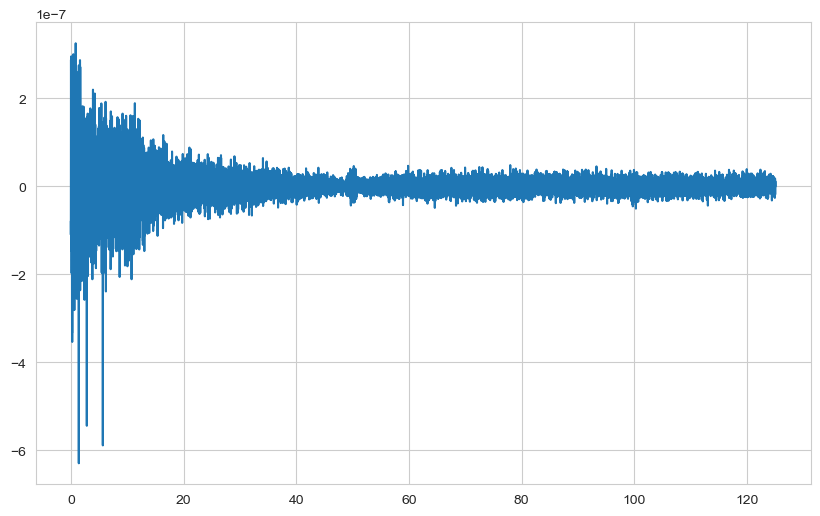

In [ ]:
ffts.plotFFT()

In [ ]:
epochs.ch_names

['EEG-Fz',
 'EEG-0',
 'EEG-1',
 'EEG-2',
 'EEG-3',
 'EEG-4',
 'EEG-5',
 'EEG-C3',
 'EEG-6',
 'EEG-Cz',
 'EEG-7',
 'EEG-C4',
 'EEG-8',
 'EEG-9',
 'EEG-10',
 'EEG-11',
 'EEG-12',
 'EEG-13',
 'EEG-14',
 'EEG-Pz',
 'EEG-15',
 'EEG-16']

In [34]:
pd.DataFrame(epochs.ch_names)

,0
0,EEG:C3
1,EEG:Cz
2,EEG:C4


In [35]:
reader = mne.io.read_raw_gdf(file_path,preload=True, eog=['EOG-left', 'EOG-central', 'EOG-right'],)
reader.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])
annotations = reader.annotations
codes = annotations.description
codeArray = []     
counter = 0
df = pd.DataFrame(reader.get_data().T, columns=[channel.replace(".","") for channel in reader.ch_names])

Extracting EDF parameters from D:\Users\User\Documents\TCC Pós Graduação\src\datasources\BCICIV_2b_gdf\B0202T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_3440\915253081.py:1: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  reader = mne.io.read_raw_gdf(file_path,preload=True, eog=['EOG-left', 'EOG-central', 'EOG-right'],)


ValueError: Channel(s) EOG-left, EOG-central, EOG-right not found, nothing dropped.

In [ ]:
reader.annotations.onset

array([   0.   ,    0.   ,  126.052,  126.052,  230.408,  230.408,
        384.636,  386.036,  388.036,  394.048,  396.048,  401.72 ,
        403.72 ,  409.528,  411.528,  417.56 ,  419.56 ,  426.004,
        428.004,  433.672,  435.672,  441.872,  443.872,  449.596,
        451.596,  457.588,  459.588,  465.212,  467.212,  472.792,
        474.792,  480.68 ,  482.68 ,  488.456,  490.456,  496.324,
        498.324,  504.804,  506.804,  512.836,  514.836,  521.1  ,
        523.1  ,  529.244,  531.244,  537.508,  539.508,  545.788,
        547.788,  554.108,  556.108,  561.756,  563.756,  569.88 ,
        571.88 ,  577.692,  579.692,  585.536,  587.536,  593.952,
        595.952,  601.968,  603.968,  609.868,  611.868,  617.972,
        619.972,  626.256,  628.256,  634.684,  636.684,  643.052,
        645.052,  651.416,  653.416,  659.588,  661.588,  667.844,
        669.844,  675.924,  677.924,  683.812,  685.812,  691.664,
        693.664,  699.364,  701.364,  707.688,  709.688,  715.

In [42]:

metrics = []


subjects_range = range(1, 10)
files = [1,2,3]
for subject in subjects_range:
    for file in files:

        fileName = f'../datasources/BCICIV_2b_gdf/B{subject:02d}{file:02d}T.gdf'
        
        reader = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG:ch01', 'EOG:ch02', 'EOG:ch03'], verbose=0)
        reader.drop_channels(['EOG:ch01', 'EOG:ch02', 'EOG:ch03'])
        annotations = reader.annotations
        codes = annotations.description
        codeArray = []     
        counter = 0
        df = pd.DataFrame(reader.get_data().T, columns=[channel.replace(".","") for channel in reader.ch_names])
        df = df[~(df == 0).all(axis=1)]
        # df = df[160:min(len(df),19680)] # Filter first and last values
        timeArray = np.array([round(x,5) for x in np.arange(0,len(df)/250,.004)])
        # timeArray = np.array([round(x,5) for x in np.arange(0,124.5,.00625)])

        for timeVal in timeArray:
            if timeVal in annotations.onset:
                counter += 1
            codeArray.append(codes[counter-1])

        df["target"] = np.array(codeArray[:len(df)]).T
    

        df.to_csv(f"../treated_files/B{subject:02d}{file:02d}T.csv")


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_3440\3363348250.py:11: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  reader = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG:ch01', 'EOG:ch02', 'EOG:ch03'], verbose=0)


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_3440\3363348250.py:11: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  reader = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG:ch01', 'EOG:ch02', 'EOG:ch03'], verbose=0)
C:\Users\Vinícius\AppData\Local\Temp\ipykernel_3440\3363348250.py:11: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  reader = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG:ch01', 'EOG:ch02', 'EOG:ch03'], verbose=0)
C:\Users\Vinícius\AppData\Local\Temp\ipykernel_3440\3363348250.py:11: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  reader = mne.io.read_raw_gdf(fileName,preload=True, eog=['EOG:ch01', 'EOG:ch02', 'EOG:ch03'], verbose=0)
C:\Users\Vinícius\AppData\Local\Temp\ipykernel_3440\3363348250.py:11: RuntimeWarning: Hi

In [45]:

metrics = []


subjects_range = range(1, 10)
files = [1,2,3]

for subject in subjects_range:
    for file in files:
            
        df = pd.read_csv(f"../treated_files/B{subject:02d}{file:02d}T.csv")

        # Iterate over unique target values
        window_size = 250
        shift_size = 125
        # for target_value in df['target'].unique():
            # Create a DataFrame for each target value
            # target_df = df[df['target'] == target_value]
            # target_df.reset_index(drop=True, inplace=True)
            # Create a list to store the windowed dataframes
        target_df = df
        # Iterate through the dataframe with the specified window and shift size
        for i in range(0, len(target_df) - window_size + 1, shift_size):
            
                # Extract the window of dat'a
                window_data = target_df[['EEG:Cz','target']].iloc[i:i + window_size]
                if len(window_data) == 250:
                    # if (window_data['target'][i] != np.max(window_data['target'][-1:]) ):
                    #     target = "T0"
                    # else:
                        # target = window_data['target'][i]

                    target = window_data['target'][i]
                    fft = FFT(window_data['EEG:Cz'],250)
                    fft.bandPassFilter(0.5,42)
                    # data = {
                    #     'mean': [np.mean(fft.data)],
                    #     'max': [np.max(fft.data)],
                    #     'min': [np.min(fft.data)],
                    #     'fmax': [fft.f[np.argmax(fft.data)]],
                    #     'energy': [sum(np.abs(fft.data)*np.abs(fft.data))/len(fft.data)],
                    #     'target': target
                    # }
                    data = fft.data
                    df = pd.DataFrame(columns= fft.f , data = data.reshape(1,41))
                    df['target'] = target
                    metrics.append(df)



    # df = df[df['target']!= "T0"]

    #         # Iterate over unique target values
    # window_size = 160
    # shift_size = 80
    # for target_value in df['target'].unique():
    #     target_df = df[df['target'] == target_value]
    #     target_df.reset_index(drop=True, inplace=True)
    # # target_df = df
    # # Iterate through the dataframe with the specified window and shift size
    #     for i in range(0, len(target_df) - window_size + 1, shift_size):
            
    #             # Extract the window of dat'a
    #             window_data = target_df[['Fp1','target']].iloc[i:i + window_size]
    #             if len(window_data) == 160:
    #                 fft = FFT(window_data['Fp1'])
    #                 fft.bandPassFilter(0.5,42)
    #                 data = {
    #                     'mean': [np.mean(fft.data)],
    #                     'max': [np.max(fft.data)],
    #                     'min': [np.min(fft.data)],
    #                     'fmax': [fft.f[np.argmax(fft.data)]],
    #                     'energy': [sum(np.abs(fft.data)*np.abs(fft.data))/len(fft.data)],
    #                     'target': window_data['target'][i]
    #                 }
    #                 metrics.append(pd.DataFrame(data))
                    
metrics = pd.concat(metrics, ignore_index=True)
metrics.to_csv("./dataframe/b2b-1-2-3-4-fft.csv")

In [46]:
metrics = pd.read_csv("./dataframe/b2b-1-2-3-4-fft.csv",index_col=0)

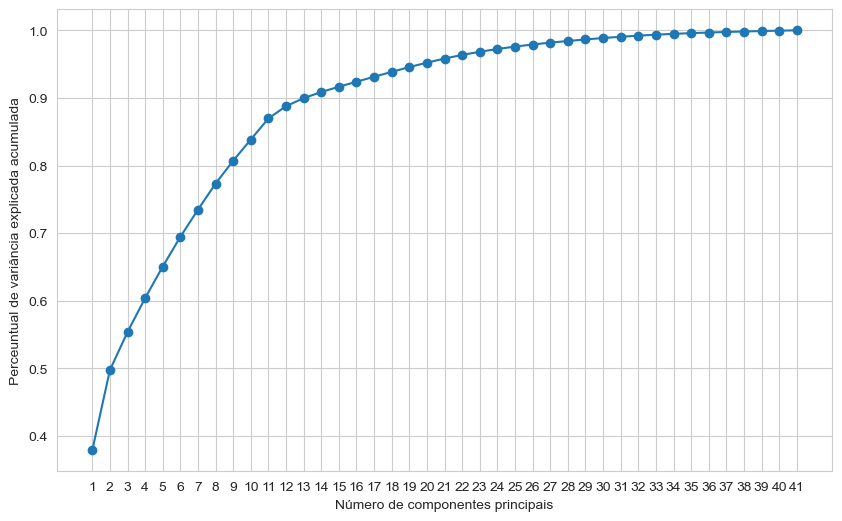

In [47]:
pca = PCA()
pca.fit(metrics.drop(columns=
                     'target'))

variancia_explicada_acumulada = np.cumsum(pca.explained_variance_ratio_)


fig, ax = plt.subplots(figsize=(10, 6))
eixo_x = list(range(1, len(variancia_explicada_acumulada)+1))
ax.plot(eixo_x, variancia_explicada_acumulada, marker="o")
ax.set_xlabel("Número de componentes principais")
ax.set_ylabel("Perceuntual de variância explicada acumulada")
ax.set_xticks(eixo_x)
plt.show()

In [48]:
pd.DataFrame(variancia_explicada_acumulada)

,0
0,0.378821
1,0.497498
2,0.553778
3,0.603955
4,0.650645
5,0.694564
6,0.734796
7,0.773357
8,0.807150
9,0.838494


In [49]:
embeddings = pca.transform(metrics.drop(columns='target'))

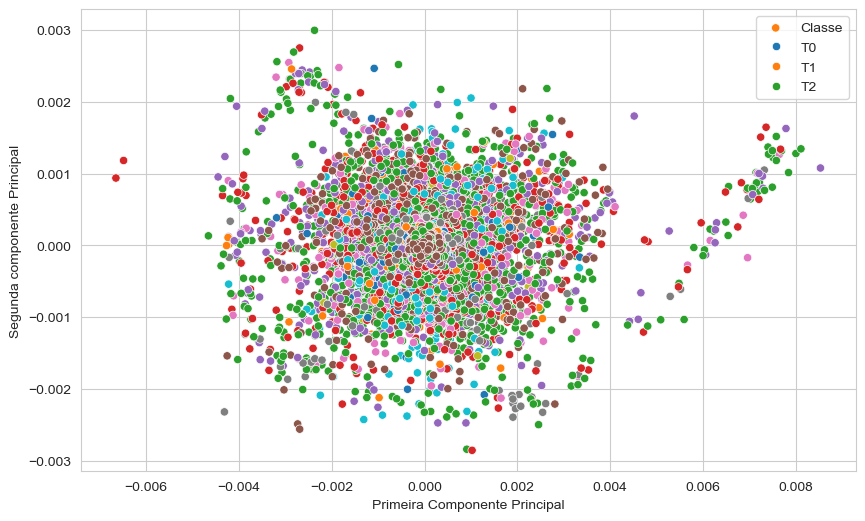

In [50]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(embeddings)[0],y=  pd.DataFrame(embeddings)[1], hue =  metrics['target'],palette="tab10")
ax.set_ylabel("Segunda componente Principal")
ax.set_xlabel("Primeira Componente Principal")
ax.legend(["Classe","T0","T1","T2"])
plt.show()

## umap = UMAP(random_state=42,n_neighbors=30,min_dist=0.05)

In [51]:
umap = UMAP(random_state=42,n_neighbors=30,min_dist=0.05)


In [52]:

label_encoder = LabelEncoder()
X_train_full, X_val, y_train_full, y_val = train_test_split(metrics.drop(columns='target'), label_encoder.fit_transform(metrics['target']), test_size=0.3, random_state=42)
umap.fit(X_train_full,y_train_full)


c:\Users\Vinícius\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.05, n_neighbors=30, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [53]:

umap_embeddings = umap.transform(X_train_full)
umap_embeddings_val = umap.transform(X_val)
umap_embeddings_all = umap.transform(metrics.drop(columns='target'))
umap_embeddings_test = umap.transform(pd.concat([X_train_full,X_val[:100]], ignore_index=True))



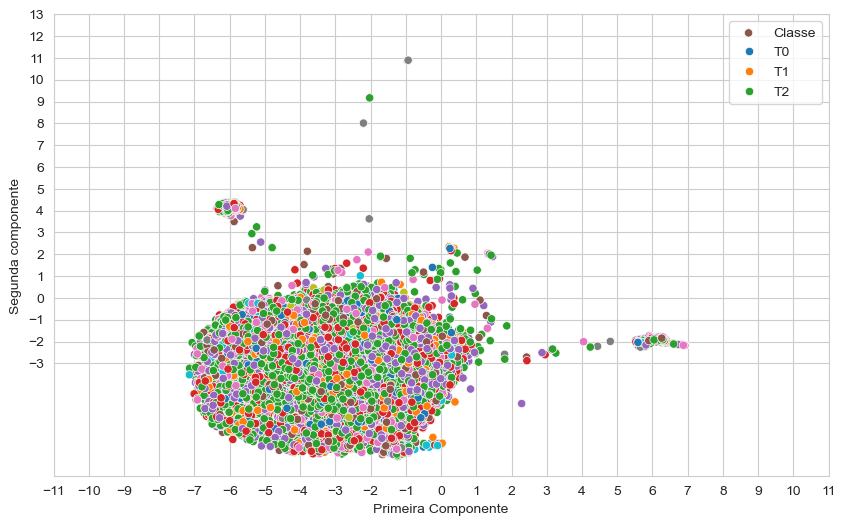

In [54]:

fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_val)[0],y=  pd.DataFrame(umap_embeddings_val)[1], hue =  y_val,palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

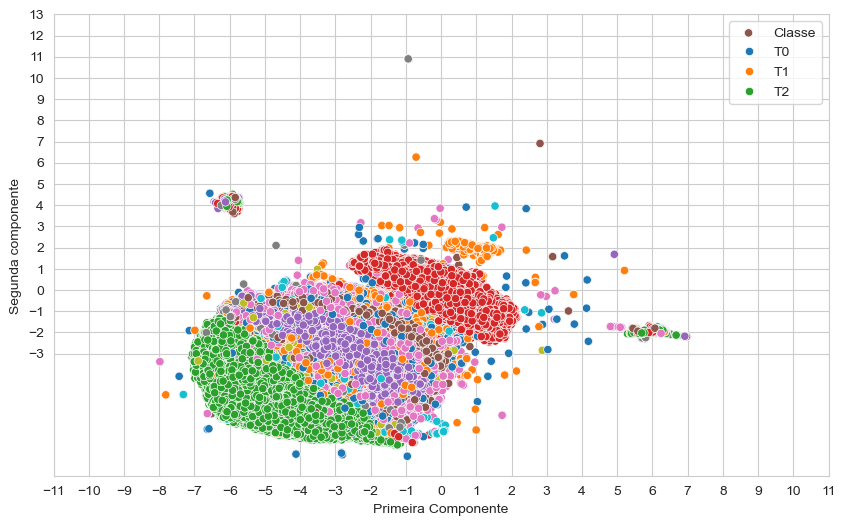

In [55]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings)[0],y=  pd.DataFrame(umap_embeddings)[1], hue =  y_train_full,palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))

plt.show()

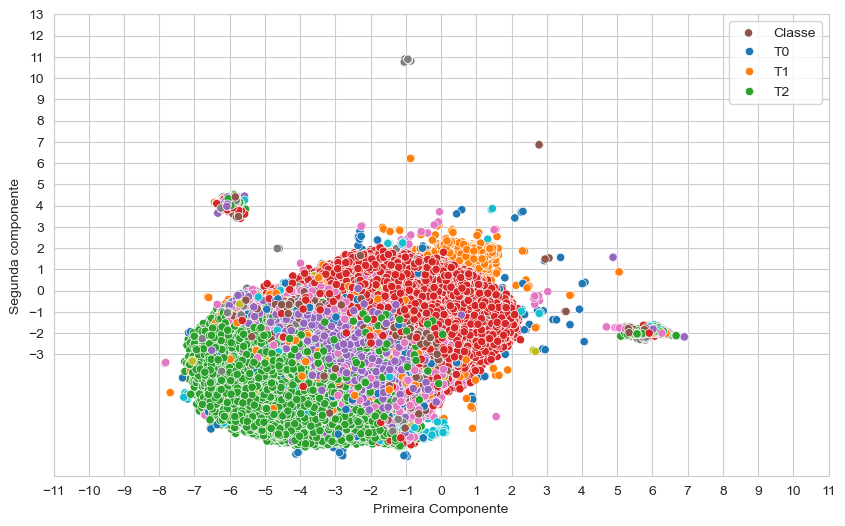

In [56]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_test)[0],y=  pd.DataFrame(umap_embeddings_test)[1], hue =  pd.concat([pd.DataFrame(y_train_full),pd.DataFrame(y_val)[:100]], ignore_index=True)[0],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

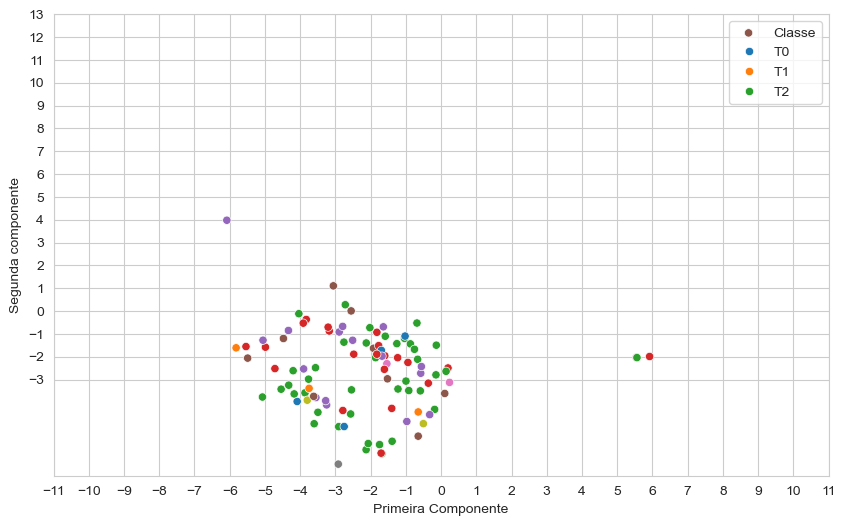

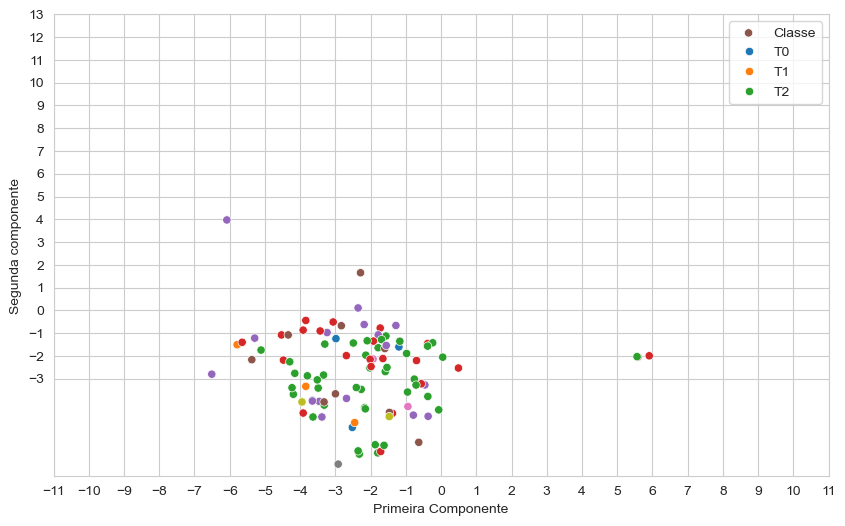

In [57]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_val)[:100][0],y=  pd.DataFrame(umap_embeddings_val)[:100][1], hue =  y_val[:100],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_test)[-100:][0],y=  pd.DataFrame(umap_embeddings_test)[-100:][1], hue =  pd.concat([pd.DataFrame(y_train_full),pd.DataFrame(y_val)[:100]], ignore_index=True)[-100:][0],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))  
plt.show()

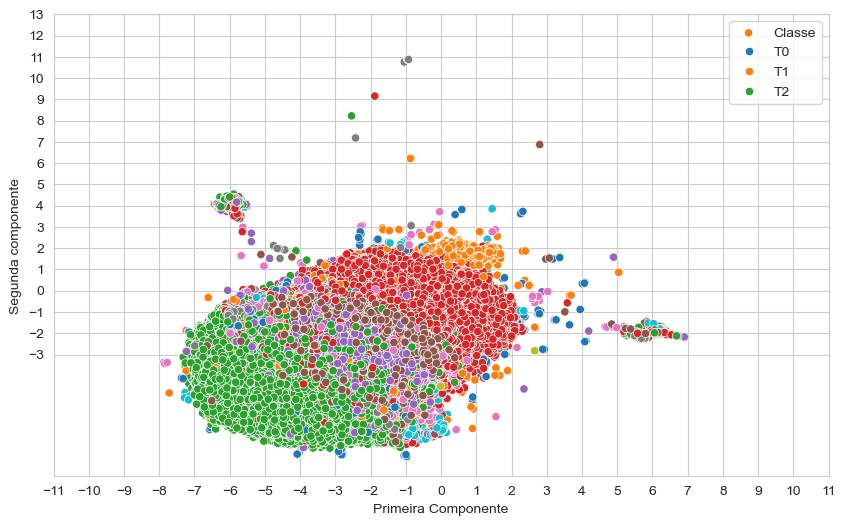

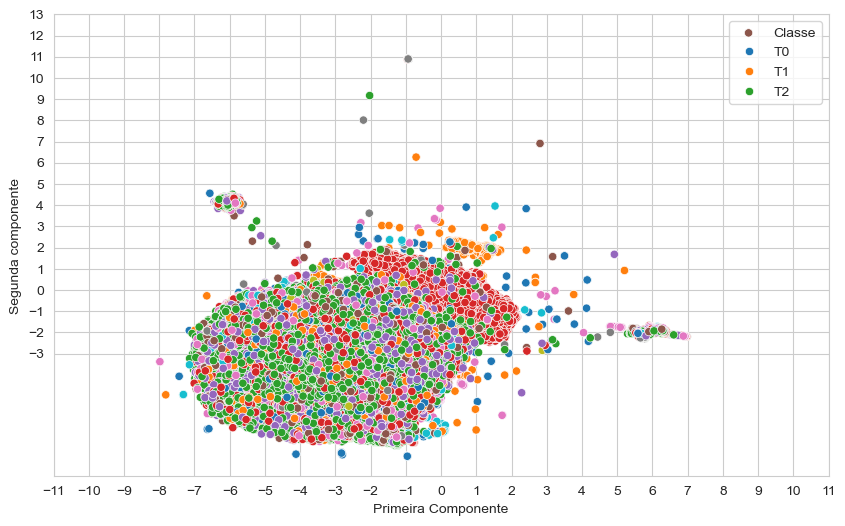

In [58]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_all)[0],y=  pd.DataFrame(umap_embeddings_all)[1], hue =   label_encoder.transform(metrics['target']),palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))         
plt.show()
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.concat([pd.DataFrame(umap_embeddings),pd.DataFrame(umap_embeddings_val)], ignore_index=True)[0],y=  pd.concat([pd.DataFrame(umap_embeddings),pd.DataFrame(umap_embeddings_val)], ignore_index=True)[1], hue =   pd.concat([pd.DataFrame(y_train_full),pd.DataFrame(y_val)], ignore_index=True)[0],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

## UMAP(random_state=42,n_neighbors=20,min_dist=0.05)

In [59]:
umap = UMAP(random_state=42,n_neighbors=20,min_dist=0.05)

In [60]:
label_encoder = LabelEncoder()
X_train_full, X_val, y_train_full, y_val = train_test_split(metrics.drop(columns='target'), label_encoder.fit_transform(metrics['target']), test_size=0.3, random_state=42)
umap.fit(X_train_full,y_train_full)


c:\Users\Vinícius\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0.05, n_neighbors=20, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [61]:

umap_embeddings = umap.transform(X_train_full)
umap_embeddings_val = umap.transform(X_val)
umap_embeddings_all = umap.transform(metrics.drop(columns='target'))
umap_embeddings_test = umap.transform(pd.concat([X_train_full,X_val[:100]], ignore_index=True))



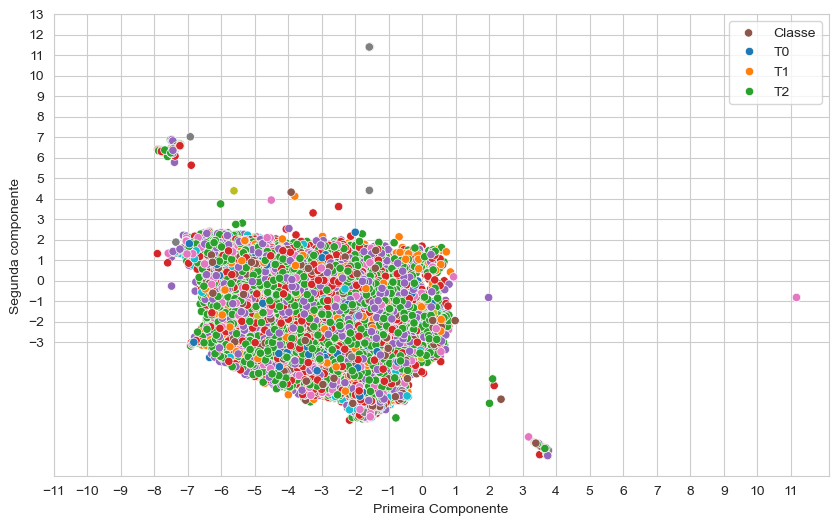

In [62]:

fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_val)[0],y=  pd.DataFrame(umap_embeddings_val)[1], hue =  y_val,palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

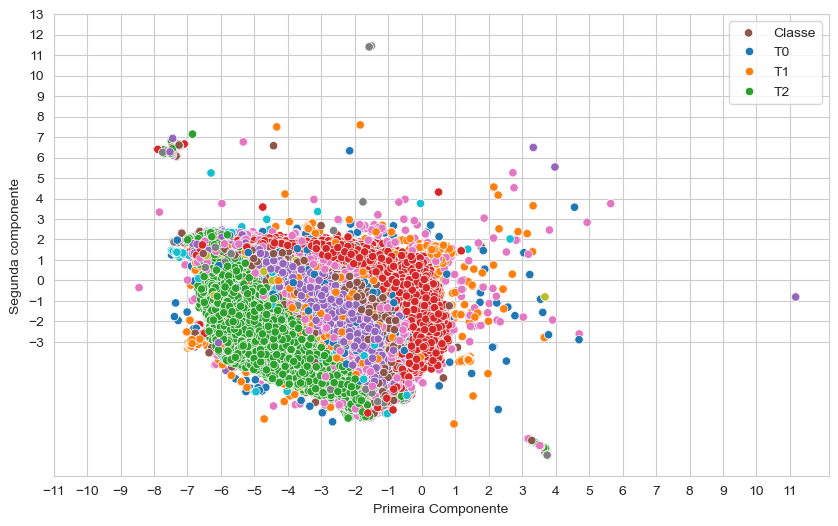

In [63]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings)[0],y=  pd.DataFrame(umap_embeddings)[1], hue =  y_train_full,palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))

plt.show()

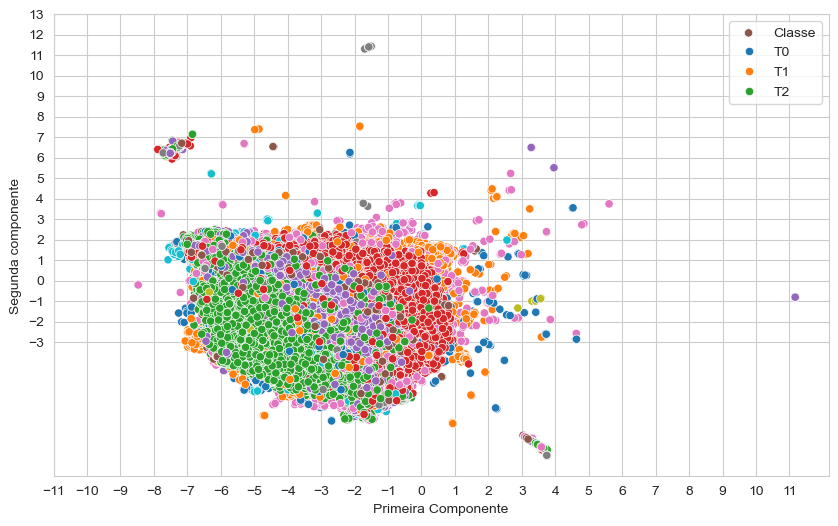

In [64]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_test)[0],y=  pd.DataFrame(umap_embeddings_test)[1], hue =  pd.concat([pd.DataFrame(y_train_full),pd.DataFrame(y_val)[:100]], ignore_index=True)[0],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

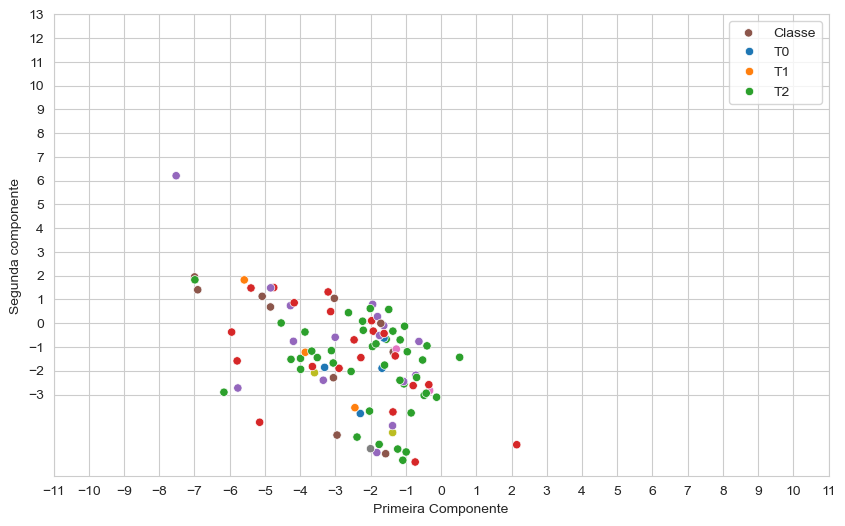

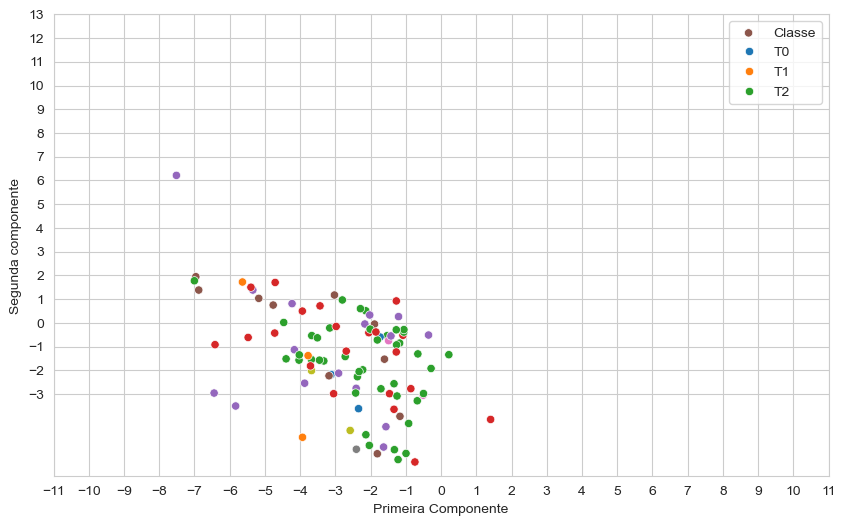

In [65]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_val)[:100][0],y=  pd.DataFrame(umap_embeddings_val)[:100][1], hue =  y_val[:100],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_test)[-100:][0],y=  pd.DataFrame(umap_embeddings_test)[-100:][1], hue =  pd.concat([pd.DataFrame(y_train_full),pd.DataFrame(y_val)[:100]], ignore_index=True)[-100:][0],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))  
plt.show()

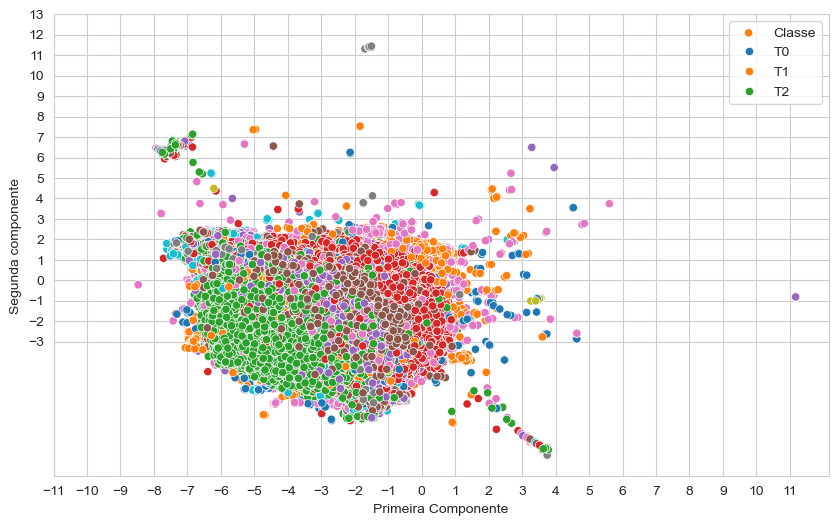

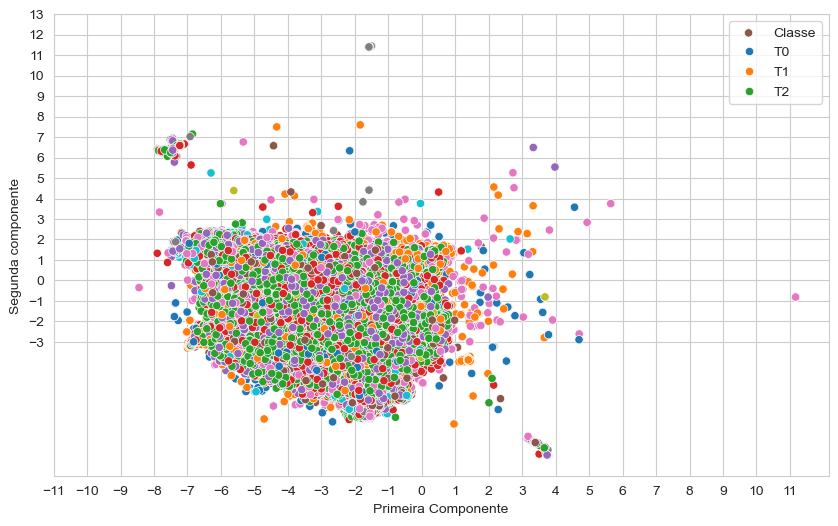

In [66]:
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.DataFrame(umap_embeddings_all)[0],y=  pd.DataFrame(umap_embeddings_all)[1], hue =   label_encoder.transform(metrics['target']),palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))         
plt.show()
fig, ax = plt.subplots()
sns.scatterplot(ax = ax, x = pd.concat([pd.DataFrame(umap_embeddings),pd.DataFrame(umap_embeddings_val)], ignore_index=True)[0],y=  pd.concat([pd.DataFrame(umap_embeddings),pd.DataFrame(umap_embeddings_val)], ignore_index=True)[1], hue =   pd.concat([pd.DataFrame(y_train_full),pd.DataFrame(y_val)], ignore_index=True)[0],palette="tab10")
ax.set_ylabel("Segunda componente")
ax.set_xlabel("Primeira Componente")
ax.legend(["Classe","T0","T1","T2"])
ax.set_xticks(list(range(-11, 11+1))) 
ax.set_yticks(list(range(-3, 13+1)))
plt.show()

## Conclusão do UMAP

É interessante que o transforme de todos os dados juntos é diferente da união das transformadas do treino e teste. Isso indica que o processo de transform do UMAP leva em consideração todos os pontos, ao invés de apenas classificar um a um. 

Apesar de estranho, não da pra afirmar que há uma melhora real em qualquer um dos dois processos descritos acima, como podemos ver no exemplo de teste, em que claramente os novos pontos se distribuiram de forma pouco relevante quando comparados aos dados de treino anteriormente vistos pelo modelo. Isso pode indicar que o prórpio modelo está em overfit, já que os dados de treino tem uma classificação melhor que os dados não vistos anteriormente pelo modelo. 

A princípio, comparando lado a lado os dois experimentos acima, o conjunto de validação que foi mostrado junto com o conjunto de treino possui uma distribuição mais agrupada. Apesar disso, como normalmente essa amostragem deve ser feita de forma separada, iremos seguir o procedimento tradicional.

Essa visualização preliminar é apenas para demonstrar as capacidades do UMAP. No modelo final iremos utilizar o mesmo número de componentes que o PCA.

In [67]:
metrics_filtered = metrics[metrics['target'].isin([
    # 768,
    769,
    770,
    771,  772
    ])]


In [68]:
metricsT2 = metrics_filtered.copy()
metricsT1 = metrics_filtered.copy()
# metricsT2 = metrics[metrics['target']!= "T0"].copy()
# metricsT1 = metrics[metrics['target']!= "T0"].copy()

In [69]:
metricsT2.loc[metricsT2['target'] != 769, 'target'] = 0
metricsT2.loc[metricsT2['target'] == 769, 'target'] = 1

metricsT1.loc[metricsT1['target'] != 770, 'target'] = 0
metricsT1.loc[metricsT1['target'] == 770, 'target'] = 1


In [70]:
df = metricsT1.copy()

In [71]:
len(metrics)

123154

In [72]:
len(metricsT2)

44953

In [73]:
len(metricsT1)

44953

In [74]:

# Supondo que você tenha os dados X e y para treinamento
label_encoder = LabelEncoder()
X_train, X_val, y_train, y_val = train_test_split(df.drop(columns='target'), label_encoder.fit_transform(df['target']), test_size=0.3, random_state=42)




In [75]:
len(X_val)

13486

In [76]:

# Definir o número de folds para a validação cruzada


model = MLPClassifier(learning_rate_init= 0.3,max_iter= 500,momentum= 0.2,hidden_layer_sizes= (6, 3))

random_grid = {
               'activation': ['logistic'],
               'solver': ['sgd'],
               
               
               }


random_search = RandomizedSearchCV(estimator= model,param_distributions=random_grid,refit='Accuracy',scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})
# Criar o modelo da rede neural


In [77]:
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

In [78]:
# skf = StratifiedKFold(n_splits=n_folds, shuffle=False, random_state=42)
# Iterar sobre os folds
# for train_index, test_index in skf.split(X_train_full, y_train_full):

random_search.fit(X_train_pca, y_train)



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(6, 3),
                                           learning_rate_init=0.3, max_iter=500,
                                           momentum=0.2),
                   param_distributions={'activation': ['logistic'],
                                        'solver': ['sgd']},
                   refit='Accuracy',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'F1': 'f1_macro'})

In [79]:
results = random_search.cv_results_

best_svm = random_search.best_estimator_ 
best_scorer_index = np.nonzero(results['rank_test_Accuracy'] == 1)[0][0]
best_scorer_index


0

c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      6857
           1     0.4915    1.0000    0.6591      6629

    accuracy                         0.4915     13486
   macro avg     0.2458    0.5000    0.3296     13486
weighted avg     0.2416    0.4915    0.3240     13486



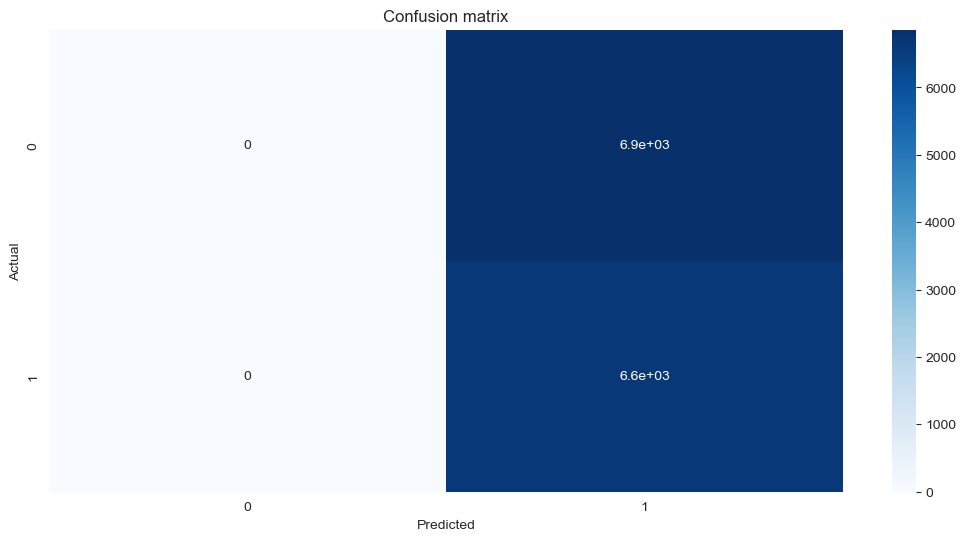

In [80]:

best_svm.fit(X_train_pca, y_train)
svm_pred = best_svm.predict(X_val_pca)

f1,acc = display_results(pd.DataFrame(y_val)[0],pd.DataFrame(svm_pred)[0])

In [81]:
model = Sequential()
model.add(Dense(15, input_dim=15, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='softmax'))
optimizer = SGD(learning_rate=0.3, momentum=0.2)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])



In [82]:
model = Sequential()
model.add(Dense(6, input_dim=6, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(30, activation='relu'))
# model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
# model.add(Dense(2, activation='softmax'))
model.add(Dense(1, activation='softmax'))
optimizer = SGD(
    learning_rate=0.01
                # , momentum=0.2
                )
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])



In [ ]:
model.fit(X_train_pca
          , y_train
          ,validation_data=(X_val_pca,y_val)
        ,epochs=100
          )

In [84]:

model_pred = model.predict(X_val_pca)
model_pred

422/422 [==============================] - 1s 964us/step


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      6857
           1     0.4915    1.0000    0.6591      6629

    accuracy                         0.4915     13486
   macro avg     0.2458    0.5000    0.3296     13486
weighted avg     0.2416    0.4915    0.3240     13486



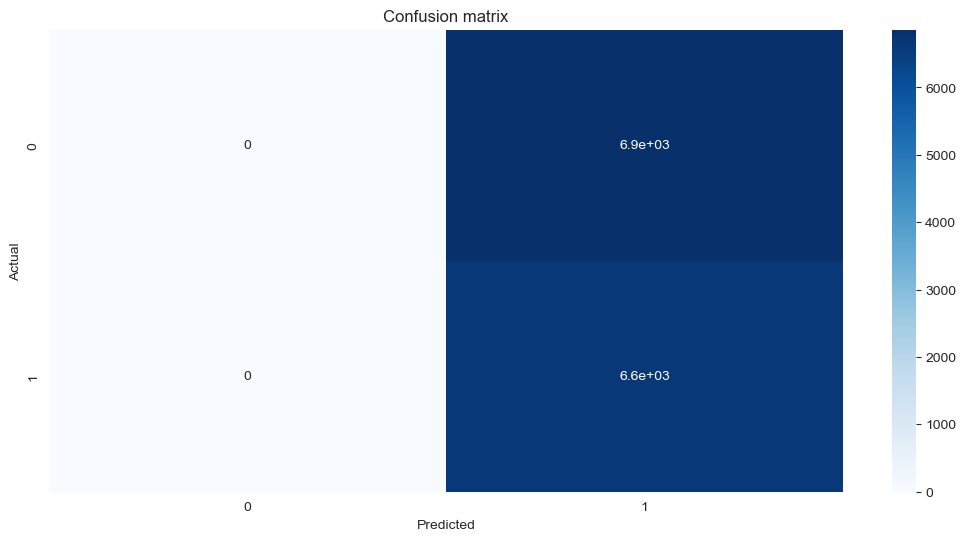

In [85]:

f1,acc = display_results(pd.DataFrame(y_val)[0],pd.DataFrame(model_pred)[0])

In [86]:
umap = UMAP(n_components=6, random_state=42,n_neighbors=30,min_dist=0.05)
umap.fit(X_train,y_train)


X_train_umap = umap.transform(X_train)
X_val_umap = umap.transform(X_val)


c:\Users\Vinícius\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [87]:
# skf = StratifiedKFold(n_splits=n_folds, shuffle=False, random_state=42)
# Iterar sobre os folds
# for train_index, test_index in skf.split(X_train_full, y_train_full):

# Definir o número de folds para a validação cruzada


model = MLPClassifier(learning_rate_init= 0.3,max_iter= 500,momentum= 0.2,hidden_layer_sizes= (6, 4))

random_grid = {
               'activation': ['relu','logistic','tanh'],
               'solver': ['sgd','adam','lbfgs'],
               
               
               }


random_search = RandomizedSearchCV(estimator= model,param_distributions=random_grid,refit='Accuracy',scoring={'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)})
# Criar o modelo da rede neural

random_search.fit(X_train_umap, y_train)



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=MLPClassifier(hidden_layer_sizes=(6, 4),
                                           learning_rate_init=0.3, max_iter=500,
                                           momentum=0.2),
                   param_distributions={'activation': ['relu', 'logistic',
                                                       'tanh'],
                                        'solver': ['sgd', 'adam', 'lbfgs']},
                   refit='Accuracy',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'F1': 'f1_macro'})

In [88]:
results = random_search.cv_results_

best_svm = random_search.best_estimator_ 
best_scorer_index = np.nonzero(results['rank_test_Accuracy'] == 1)[0][0]
best_svm.get_params()



{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (6, 4),
 'learning_rate': 'constant',
 'learning_rate_init': 0.3,
 'max_fun': 15000,
 'max_iter': 500,
 'momentum': 0.2,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

              precision    recall  f1-score   support

           0     0.5112    0.6434    0.5698      6857
           1     0.4965    0.3637    0.4199      6629

    accuracy                         0.5059     13486
   macro avg     0.5039    0.5036    0.4948     13486
weighted avg     0.5040    0.5059    0.4961     13486



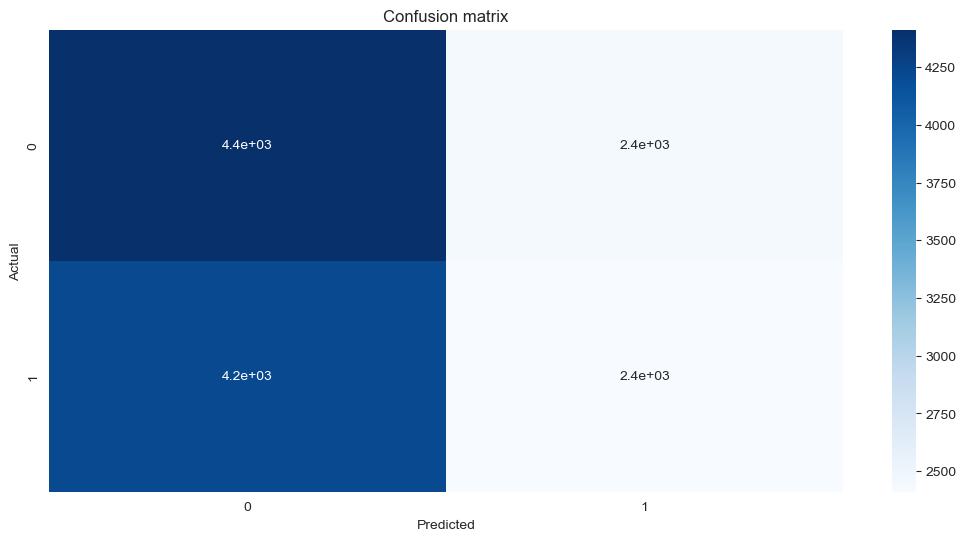

In [89]:
best_svm.fit(X_train_umap, y_train)
svm_pred_umap = best_svm.predict(X_val_umap)

f1,acc = display_results(pd.DataFrame(y_val)[0],pd.DataFrame(svm_pred_umap)[0])

In [90]:
model = Sequential()
model.add(Dense(6, input_dim=6, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(30, activation='relu'))
# model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
# model.add(Dense(2, activation='softmax'))
model.add(Dense(1, activation='softmax'))
optimizer = SGD(
    learning_rate=0.01
                # , momentum=0.2
                )
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(X_train_umap, y_train
          ,validation_data=(X_val_umap,y_val)
        ,epochs=100
          )


Epoch 1/100
984/984 [==============================] - 2s 2ms/step - loss: 0.1942 - accuracy: 0.4960 - val_loss: 1.1897 - val_accuracy: 0.4915
Epoch 2/100
984/984 [==============================] - 2s 2ms/step - loss: 0.0749 - accuracy: 0.4960 - val_loss: 1.2893 - val_accuracy: 0.4915
Epoch 3/100
984/984 [==============================] - 2s 2ms/step - loss: 0.0449 - accuracy: 0.4960 - val_loss: 1.3491 - val_accuracy: 0.4915
Epoch 4/100
984/984 [==============================] - 2s 2ms/step - loss: 0.0318 - accuracy: 0.4960 - val_loss: 1.3914 - val_accuracy: 0.4915
Epoch 5/100
984/984 [==============================] - 2s 2ms/step - loss: 0.0245 - accuracy: 0.4960 - val_loss: 1.4164 - val_accuracy: 0.4915
Epoch 6/100
984/984 [==============================] - 2s 2ms/step - loss: 0.0199 - accuracy: 0.4960 - val_loss: 1.4421 - val_accuracy: 0.4915
Epoch 7/100
984/984 [==============================] - 2s 2ms/step - loss: 0.0167 - accuracy: 0.4960 - val_loss: 1.4627 - val_accuracy: 0.4915

  1/422 [..............................] - ETA: 26s

422/422 [==============================] - 0s 867us/step
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      6857
           1     0.4915    1.0000    0.6591      6629

    accuracy                         0.4915     13486
   macro avg     0.2458    0.5000    0.3296     13486
weighted avg     0.2416    0.4915    0.3240     13486



c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinícius\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


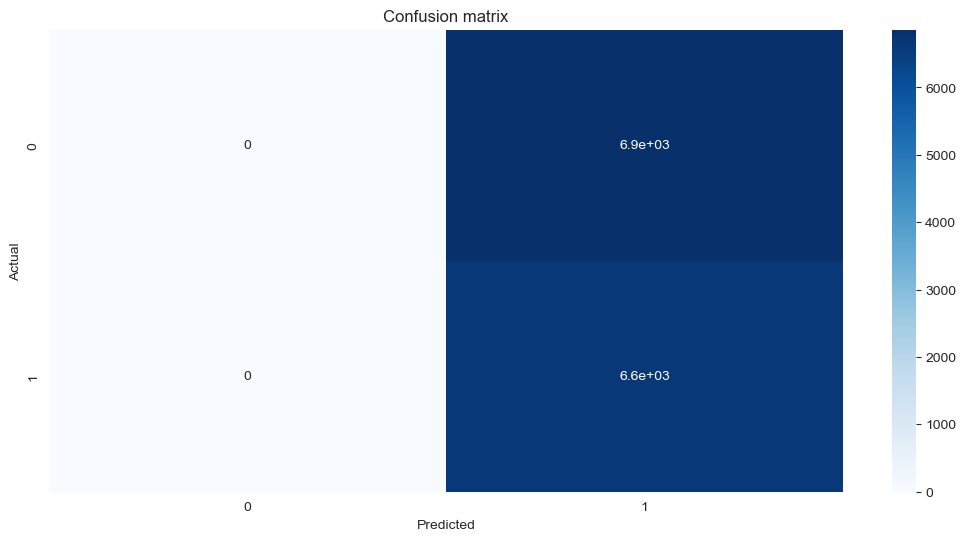

In [91]:
model_pred_umap = model.predict(X_val_umap)
model_pred_umap
f1,acc = display_results(pd.DataFrame(y_val)[0],pd.DataFrame(model_pred_umap)[0])